In [294]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Data cleaning
La fonction clean_df prend le fichier csv et effectue les étapes de nettoyages nécessaire. On se débarasse tout d'abord des variables non désirées. On convertit ensuite la variable DATE en date object. On enlève les lignes dupliquées, puis on remplace les NAs. Finalement on ajoute les variables temporelles month, day et year

In [297]:
def clean_df(df_csv):
    df=pd.read_csv(df_csv)
    df.drop(['VALUE_DATE', 'CHQ.NO.','.'], axis=1, inplace=True)
    #convert DATE to date format
    date=pd.to_datetime(df.DATE)
    df["DATE"]=date
    #Remove duplicates
    df.drop_duplicates(keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    #Every transaction contains one action (deposit or withdrawal)
    values = {'TRANSACTION_DETAILS': 'unknown', 'WITHDRAWAL_AMT': 0, 'DEPOSIT_AMT': 0}
    df.fillna(value=values,inplace=True)
    #Add year and month variables
    df['year']=df['DATE'].dt.year
    df['month']=df['DATE'].dt.month
    df["day"]=df["DATE"].dt.day
    
    # zero in withdrawal means that the transaction is  deposit, there is a repeated information here
    #amount is  the new variable that contains the amount of transaction
    # the variable amount_type is 1 if the amount is a withdrawal and 0 if it is deposit

    # VARIABLE amount
    df["amount"]= df["WITHDRAWAL_AMT"]+df["DEPOSIT_AMT"]

    #VARIABLE amount_type
    df['amount_type']=0
    w1=df["WITHDRAWAL_AMT"]!=0
    df["amount_type"]=df['amount_type'].mask(w1 , 1)
    return df

In [298]:
df=clean_df("bankcsv.csv")

In [299]:
df.describe()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,year,month,day,amount,amount_type
count,1.161620e+05,1.161620e+05,1.161620e+05,116162.000000,116162.000000,116162.000000,1.161620e+05,116162.000000
mean,2.067812e+06,2.052037e+06,-1.404802e+09,2016.869992,6.680197,15.614616,4.119849e+06,0.460779
std,7.697182e+06,6.652533e+06,5.348783e+08,1.130985,3.492062,8.602452,9.747630e+06,0.498461
min,0.000000e+00,0.000000e+00,-2.045201e+09,2015.000000,1.000000,1.000000,1.000000e-02,0.000000
25%,0.000000e+00,0.000000e+00,-1.690383e+09,2016.000000,4.000000,8.000000,1.269616e+04,0.000000
50%,0.000000e+00,5.000000e+03,-1.661382e+09,2017.000000,7.000000,15.000000,2.734060e+05,0.000000
75%,2.669975e+04,5.000000e+05,-1.236889e+09,2018.000000,10.000000,23.000000,4.999997e+06,1.000000
max,4.594475e+08,5.448000e+08,8.500000e+06,2019.000000,12.000000,31.000000,5.448000e+08,1.000000


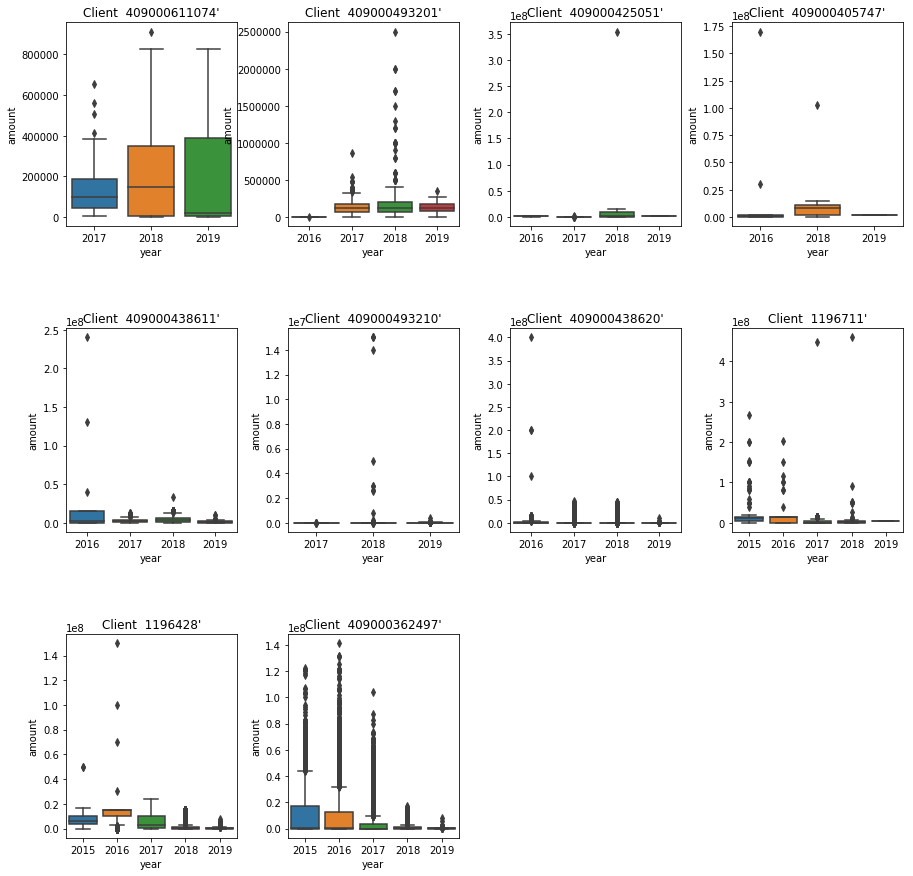

In [300]:
#Description

clients= list(df["Account_No"].unique())
n=0
plt.figure(1 , figsize = (15 , 15))

for f in clients:
    n += 1
    plt.subplot(3 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    ax = sns.boxplot(x="year", y="amount", data=df[(df["Account_No"]==f) & (df["amount_type"]==1)])
    plt.title('Client  {}'.format(f))

# Travail sur une année 2018

La fonction df18_outliersfree prend la dataframe df issue de la fonction clean_df et en extrait les transactions émises en 2018 afin de détecter par la suite les comprtements distincts des clients.

On enlève tout d'abord via cette fonction les points aberrants par la méthode IQR et ce pour chaque client à part

In [301]:
#Let's detect patterns on one year
def df18_outliersfree(df):
    df18=df[df["year"]==2018]
    df18=df18[["Account_No",'DATE',"month","day","WITHDRAWAL_AMT","DEPOSIT_AMT","BALANCE_AMT"]]
    df18.reset_index(drop=True, inplace=True)
    features1=['WITHDRAWAL_AMT','DEPOSIT_AMT','BALANCE_AMT']
    Q1=[]
    Q3=[]
    IQR=[]
    for acc in clients:
        q1=df18[df18["Account_No"]==acc][features1].quantile(0.25)
        q3=df18[df18["Account_No"]==acc][features1].quantile(0.75)
        Q1.append(q1)
        Q3.append(q3)
        IQR.append(q3 - q1)


    appended_data = []

    for i,acc in enumerate(clients):
        cond_acc=df18["Account_No"]==acc
        data=df18[cond_acc]
        data=data[~((data[features1] < (Q1[i]-1.5 * IQR[i] )) |(data[features1] > (Q3[i] + 1.5 * IQR[i] ))).any(axis=1)]
        appended_data.append(data)

    df18_outliersfree = pd.concat(appended_data)
    df18_outliersfree.reset_index(drop=True, inplace=True)
    return df18_outliersfree

In [302]:
df18_outliersfree=df18_outliersfree(df)
df18_outliersfree.head()

,Account_No,DATE,month,day,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
0,409000611074',2018-01-01,1,1,14000.0,0.0,697823.0
1,409000611074',2018-01-01,1,1,54250.0,0.0,643573.0
2,409000611074',2018-01-02,1,2,147500.0,0.0,496073.0
3,409000611074',2018-01-03,1,3,0.0,500000.0,996073.0
4,409000611074',2018-01-03,1,3,323500.0,0.0,672573.0


## Séries temporelles

La fonction df18_ts prend la dataframe issue de la fonction df18_outliersfree et essaie de construire une dataframe qui représente chaque point de date par une seule observation afin de travailler avec les séries temporelles par la suite.

On construit withd_by_date qui est la somme des valeurs retirées par chaque client sur chaque date, dep_by_date, la somme des valeurs déposées par chaque client sur chaque date, et finalement la variable Balance_updated qui est la dernière valeur du solde enregistrée sur chaque date

In [303]:
# faire la somme des  withdrawals et deposits par date pour faire des plots time 

def df18_ts(df18_outliersfree):
    clients= list(df18_outliersfree["Account_No"].unique())
    stats_withd = df18_outliersfree.groupby(['Account_No','DATE'])['WITHDRAWAL_AMT'].agg(['sum'])
    stats_withd.columns = [ 'withd_by_date']


    stats_dep = df18_outliersfree.groupby(['Account_No','DATE'])['DEPOSIT_AMT'].agg(['sum'])
    stats_dep.columns = [ 'dep_by_date']



    #Affecter les valeurs ajoutées au df
    #pour withdrawal
    df18_outliersfree["withd_by_date"]=0
    for acc in clients:
        cond_acc=df18_outliersfree["Account_No"]== acc
       # df_acc=df[cond_acc]
        dates=stats_withd.loc[acc,:].index # all dates not duplicated by which the sum is computed
        for d in dates:
            cond_date=df18_outliersfree["DATE"]==d
            value_counted=stats_withd.loc[acc,:].loc[d,:]["withd_by_date"]

            df18_outliersfree["withd_by_date"]=df18_outliersfree['withd_by_date'].mask(cond_acc & cond_date , value_counted)


    #pour deposit
    df18_outliersfree["dep_by_date"]=0
    for acc in clients:
        cond_acc=df18_outliersfree["Account_No"]== acc
       # df_acc=df[cond_acc]
        dates=stats_dep.loc[acc,:].index # all dates not duplicated by which the sum is computed
        for d in dates:
            cond_date=df18_outliersfree["DATE"]==d
            value_counted=stats_dep.loc[acc,:].loc[d,:]["dep_by_date"]

            df18_outliersfree["dep_by_date"]=df18_outliersfree['dep_by_date'].mask(cond_acc & cond_date , value_counted)

    #one row for every client_id + DATE is enough
    df18_ts=df18_outliersfree.groupby(['Account_No','DATE']).first().reset_index()

    # add a column Balance_updated for last value of balance recorded fo each date
    last_bal=df18_outliersfree.groupby(['Account_No','DATE']).last().reset_index()["BALANCE_AMT"]
    df18_ts['Balance_updated']=last_bal
    df18_ts.drop(["WITHDRAWAL_AMT","DEPOSIT_AMT","BALANCE_AMT"], axis=1, inplace=True)
    return df18_ts


In [304]:
df18_ts=df18_ts(df18_outliersfree)
df18_ts.shape

(2035, 7)

In [305]:
df18_ts.head()

,Account_No,DATE,month,day,withd_by_date,dep_by_date,Balance_updated
0,1196428',2018-01-01,1,1,0.00,1408920.67,-1.669206e+09
1,1196428',2018-01-02,1,2,0.00,452336.73,-1.685731e+09
2,1196428',2018-01-03,1,3,2723.23,724458.09,-1.679765e+09
3,1196428',2018-01-04,1,4,100000.00,702555.00,-1.685324e+09
4,1196428',2018-01-05,1,5,1591.01,1128626.00,-1.684513e+09


### Plots
Ici on trace les différentes séries temporelles issues de la dataframe résultat de la fonction df18_ts ainsi que la composante tendancielle de withd_by_date par l'intermédiaire des moyennes glissantes

In [306]:
#put date in index
df18_ts=df18_ts.set_index('DATE')
df18_ts.head()

,Account_No,month,day,withd_by_date,dep_by_date,Balance_updated
DATE,,,,,,
2018-01-01,1196428',1,1,0.00,1408920.67,-1.669206e+09
2018-01-02,1196428',1,2,0.00,452336.73,-1.685731e+09
2018-01-03,1196428',1,3,2723.23,724458.09,-1.679765e+09
2018-01-04,1196428',1,4,100000.00,702555.00,-1.685324e+09
2018-01-05,1196428',1,5,1591.01,1128626.00,-1.684513e+09


<Figure size 1080x360 with 0 Axes>

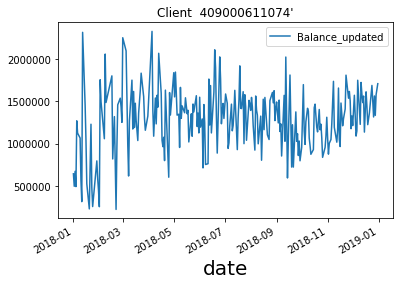

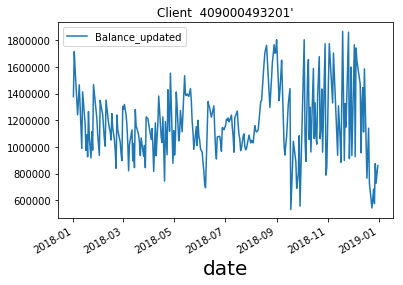

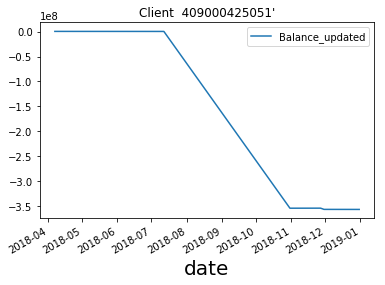

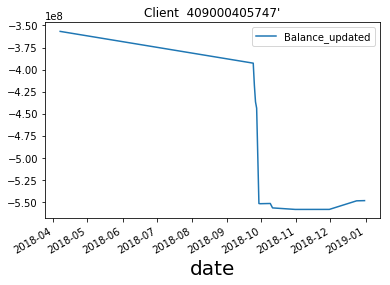

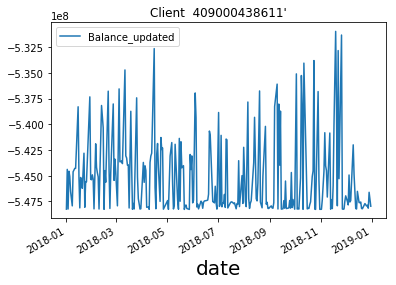

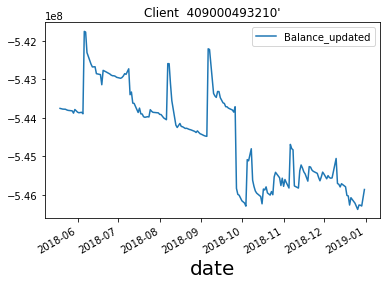

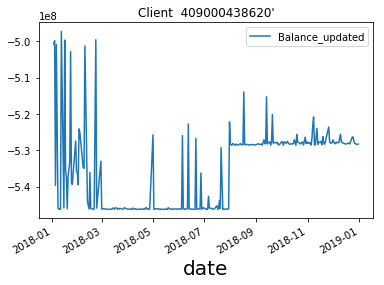

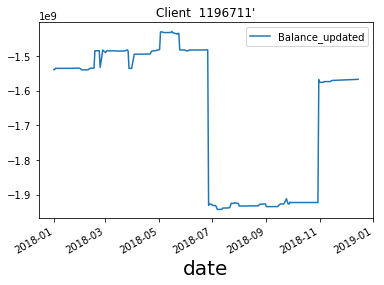

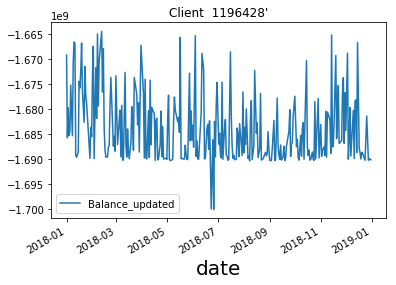

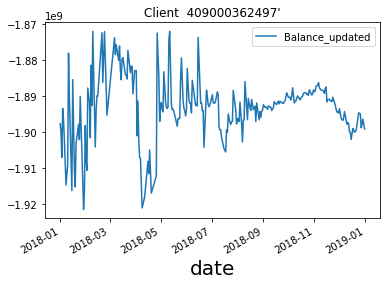

In [307]:
# plot of time series
plt.figure(1 , figsize = (15 , 5))
n=0
for acc in clients:
    df18_ts[df18_ts["Account_No"]==acc][['Balance_updated']].plot()
    plt.xlabel('date', fontsize=20)
    plt.title('Client  {}'.format(acc))

<Figure size 1080x360 with 0 Axes>

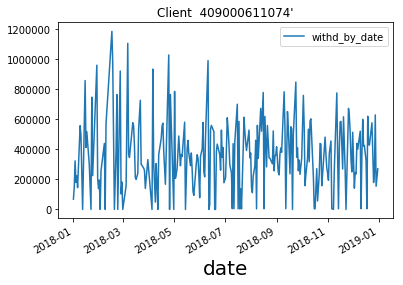

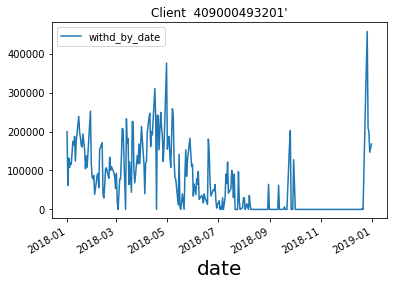

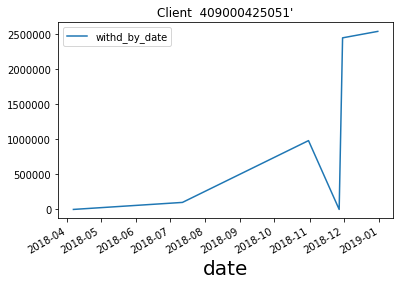

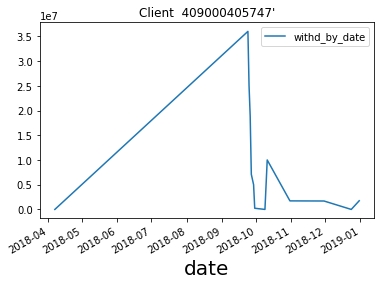

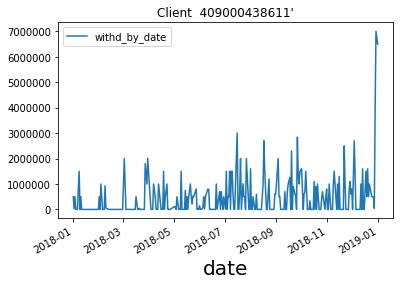

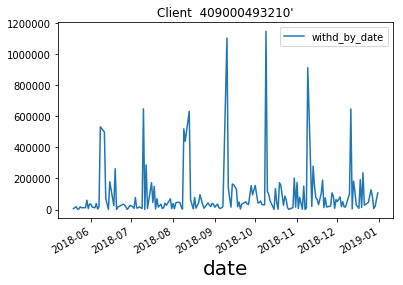

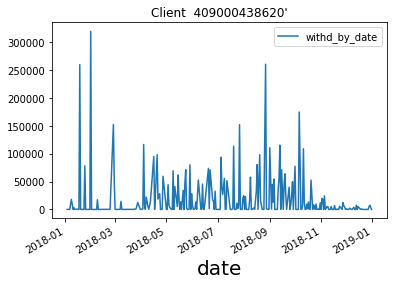

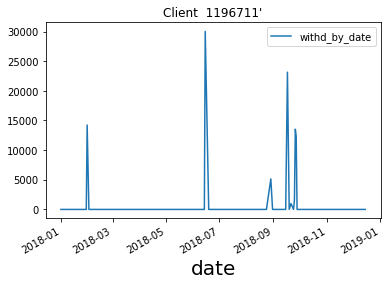

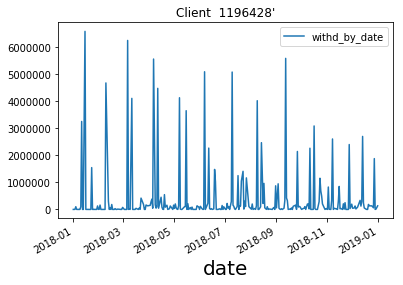

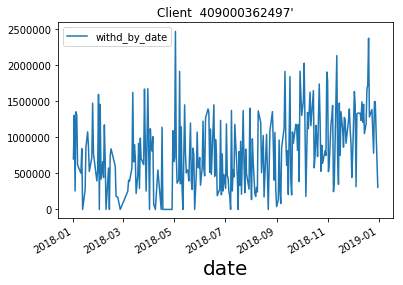

In [308]:
# plot of time series
plt.figure(1 , figsize = (15 , 5))
n=0
for acc in clients:
    df18_ts[df18_ts["Account_No"]==acc][['withd_by_date']].plot()
    plt.xlabel('date', fontsize=20)
    plt.title('Client  {}'.format(acc))

<Figure size 1080x360 with 0 Axes>

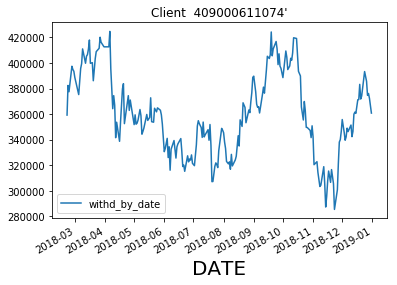

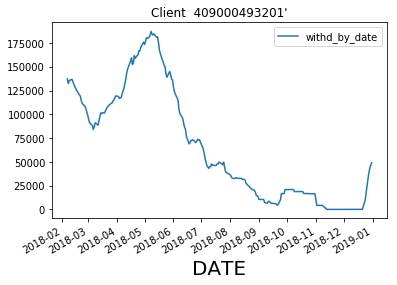

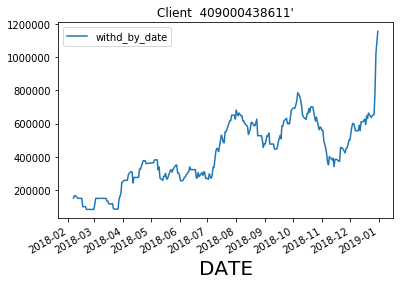

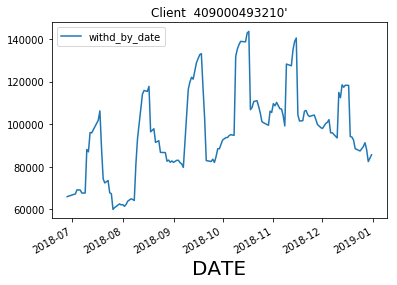

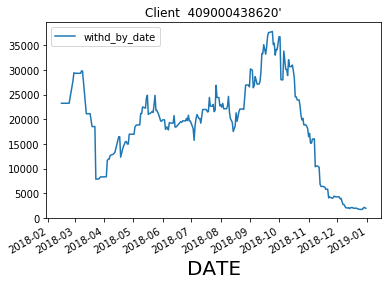

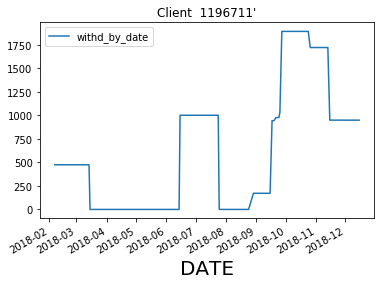

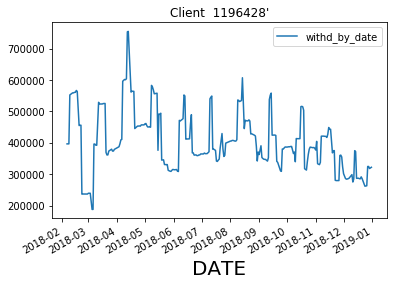

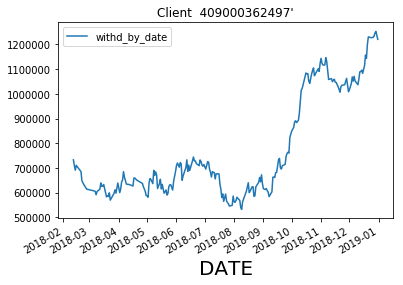

In [309]:
#trend by moving average
# plot of time series
plt.figure(1 , figsize = (15 , 5))
n=0
for acc in ["409000611074'",
 "409000493201'",
 "409000438611'",
 "409000493210'",
 "409000438620'",
 "1196711'",
 "1196428'",
 "409000362497'"]:
    dep_by_date = df18_ts[df18_ts["Account_No"]==acc][['withd_by_date']]
    dep_by_date.rolling(30).mean().plot()
    plt.xlabel('DATE', fontsize=20)
    plt.title('Client  {}'.format(acc))


## Aggregations based on clients ids

La fonction df_clustering prend la dataframe issue de la fonction df_ts et en essaie d'extraire de nouvelles features afin cette fois_ci de représenter chaque client par un point et le mettre dans un dataset qui sera utilisé pour le clustering des clients.

On crée la variable number_of_transactions qui compte le nombre de transactions faites par chaque client sur l'année en question (2018),    mean_Balance_updated est la variable représentant la moyenne des valeurs prises par le solde Balance_updated au fil de l'année. std_ma_withd représente l'écart-type des valeurs de la moyenne glissante par laquelle le traçage de la composante tendancielle a été effectué. Et finalement maxWithd_month qui représente le mois sur lequel la variable withd_by_date a enregistré une valeur maximale durant l'année


In [310]:
#COUNT NUMBER OF TRANSACTIONS PER CLIENT
def df_clustering(df18_ts):
    df18_ts.reset_index(inplace=True)
    clients= list(df18_ts["Account_No"].unique())
    df18_ts["number_of_transactions"]=0
    df_clustering=df18_ts.groupby('Account_No').agg('count')

    df_clustering.drop(['month','day','withd_by_date','dep_by_date','Balance_updated','DATE'], inplace= True, axis=1)

    # ADD MEAN  of Balance_updated over the whole year
    #mean and max highly correlated
    #max deposit and max withd highly correlated
    df_clustering['mean_Balance_updated']= df18_ts.groupby('Account_No').agg('mean')['Balance_updated']
    df_clustering.reset_index(inplace=True)

    #Add features explaining tendencies
    #std_ma_withd
    #dictionary of std of rolling averages of withdrawal (keys are clients ids)
    dic_with_std={}
    for acc in clients:
        cond_acc=df18_ts["Account_No"]== acc
        with_by_date = df18_ts[df18_ts["Account_No"]==acc][['withd_by_date']]
        value=np.std(with_by_date.rolling(30).mean())
        dic_with_std.update( {acc : value[0]} )


    df_clustering["std_ma_withd"]=0
    #df_clustering["max_ma_dep"]=0
    for acc in clients:
        cond_acc=df_clustering["Account_No"]== acc
        df_clustering["std_ma_withd"]=df_clustering["std_ma_withd"].mask(cond_acc,dic_with_std.get(acc))

    values = {'std_ma_withd': 0}
    df_clustering.fillna(value=values,inplace=True)


    #ADD variable maxWithd_month to indecate in which month the withdrawal has been maximal

    data=df18_ts.groupby(['Account_No','month']).agg('max')
    data.reset_index(inplace=True)
    d=data.groupby('Account_No').agg('max')['withd_by_date']

    d=pd.DataFrame(d)
    d.reset_index(inplace=True)

    df_clustering["maxWithd_month"]=0
    for i in range(len(d)):
        cond= (data["Account_No"]==d["Account_No"].iloc[i]) & (data["withd_by_date"]==d["withd_by_date"].iloc[i])
        cond1=df_clustering["Account_No"]==d["Account_No"].iloc[i]
        value = data.loc[cond , 'month' ].iloc[0]
        df_clustering["maxWithd_month"]= df_clustering["maxWithd_month"].mask(cond1, value)
    return df_clustering

In [311]:
df_clustering=df_clustering(df18_ts)
df_clustering

,Account_No,number_of_transactions,mean_Balance_updated,std_ma_withd,maxWithd_month
0,1196428',290,-1.684033e+09,93028.507226,1
1,1196711',215,-1.656340e+09,634.131714,6
2,409000362497',265,-1.893231e+09,205241.582277,5
3,409000405747',13,-4.979762e+08,0.000000,9
4,409000425051',6,-2.369639e+08,0.000000,12
5,409000438611',277,-5.451921e+08,193947.496702,12
6,409000438620',272,-5.347802e+08,9083.278039,1
7,409000493201',270,1.164402e+06,58419.991614,12
8,409000493210',173,-5.444580e+08,20766.070997,10
9,409000611074',254,1.283176e+06,31781.982330,2


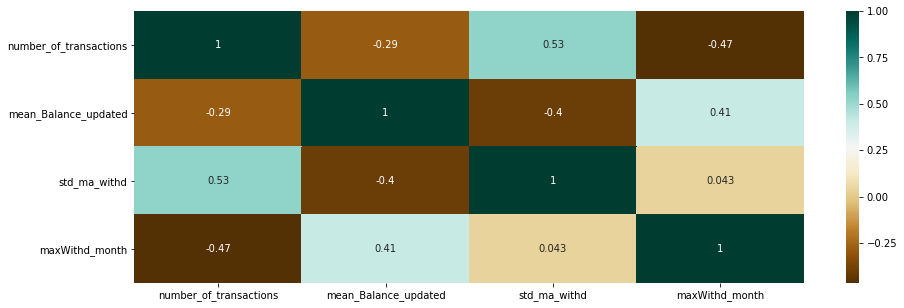

In [312]:
#Corrélations entre les variables de df_clustering

plt.figure(figsize=(15,5))
c= df_clustering.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

## Préparer df_clustering pour appliquer K-Means

In [313]:
#features distribution
def distributions(df_clustering):
    features=list(df_clustering.columns)
    features.remove('Account_No')
    plt.figure(1 , figsize = (20 , 10))
    n = 0 
    for x in features:
        n += 1
        plt.subplot(2 , 3 , n)
        plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
        sns.distplot(df_clustering[x] , bins = 20)
        plt.title('Distplot of {}'.format(x))
    return plt.show()

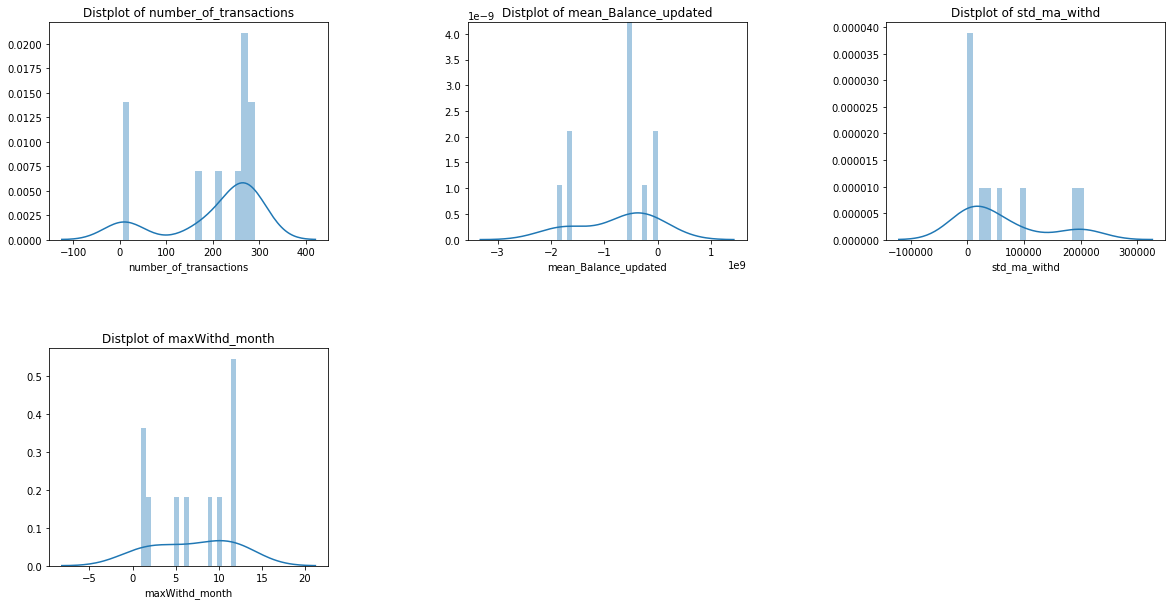

In [314]:
distributions(df_clustering)

In [315]:
#Skewness des variables de df_clustering, il n'est pas nécessaire d'appliquer le log afin de normaliser les valeurs
df_clustering.skew()

number_of_transactions   -1.397406
mean_Balance_updated     -0.726591
std_ma_withd              1.261822
maxWithd_month           -0.223370
dtype: float64

La fonction df_clustering_std est utilisée pour standardiser la data en appliquant StandardScaler

In [316]:
#Standarize features values to apply clustering methods
def df_clustering_std(df_clustering):
    features=list(df_clustering.columns)
    features.remove('Account_No')
    x = df_clustering.loc[:, features].values
    #Standardizing the features
    x = StandardScaler().fit_transform(x)
    df_clustering[features] =x
    return df_clustering

In [317]:
df_clustering_std=df_clustering_std(df_clustering)

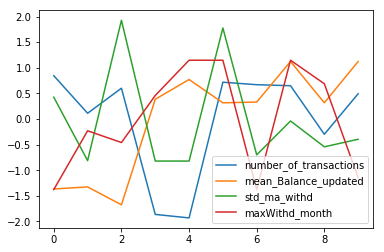

In [318]:
df_clustering_std.plot()

# Application de K-Means

La fonction plot_k permet d'appliquer la m'éthode de coude (elbow method) afin de choisir par la suite le nombre de clusters k optimale. Pour ce faire, la fonction ci-dessous permet de tracer la somme des carrés de distance entre les points de données et le centroïde respectif du cluster auquel le point de données appartient en fonction de k. On prend la valeur k à l'endroit où la fonction de coût commence à s'aplatir et à former un coude.

In [319]:
def plot_k(df_clustering_std):
    features=list(df_clustering_std.columns)
    features.remove('Account_No')

    X1 = df_clustering_std[features].iloc[: , :].values
    inertia = []
    for n in range(1 , 11):
        algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
        algorithm.fit(X1)
        inertia.append(algorithm.inertia_)

    #Selecting N Clusters based in Inertia (Squared Distance between Centroids and data points, should be less)
    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    return plt.show()

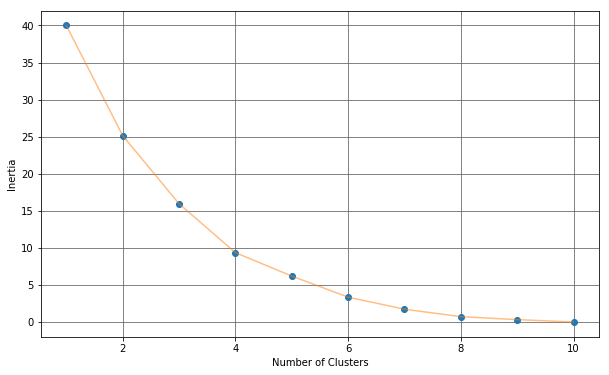

In [320]:
plot_k(df_clustering_std)

La fonction kmeans permet, en la donnant la data standardisée et le k optimal, de "fitter" le modèle kmeans par les valeurs de la data mise en argument et retourner les labels des clusters ainsi que les coordonnées des centroides

In [321]:
def kmeans(df_clustering_std,k):

    algorithm = (KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
    X1 = df_clustering_std[features].iloc[: , :].values
    algorithm.fit(X1)
    labels = algorithm.labels_
    centroids = algorithm.cluster_centers_
    labelsncentroids=[labels,centroids]
    return labelsncentroids

In [322]:
labels=kmeans(df_clustering_std,6)[0]
centroids=kmeans(df_clustering_std,6)[1]


On affecte les labes aux clients qui convient dans le dataset df_clustering_std et on visualise nos clusters

In [323]:
import plotly.graph_objs as go
import plotly as py

df_clustering_std['cluster'] =  labels
trace1 = go.Scatter3d(
    x= df_clustering_std['mean_Balance_updated'],
    y= df_clustering_std['std_ma_withd'],
    z= df_clustering_std['number_of_transactions'],
    mode='markers',
     marker=dict(
        color = df_clustering_std['cluster'], 
        size= 20,
        line=dict(
            color= df_clustering_std['cluster'],
            width= 12
        ),
        opacity=0.8
     )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'mean_Balance_updated'),
            yaxis = dict(title  = 'std_ma_withd'),
            zaxis = dict(title  = 'number_of_transactions')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)


In [324]:
df_clustering_std

,Account_No,number_of_transactions,mean_Balance_updated,std_ma_withd,maxWithd_month,cluster
0,1196428',0.845400,-1.365898,0.425008,-1.376494,1
1,1196711',0.112394,-1.325004,-0.812250,-0.229416,5
2,409000362497',0.601065,-1.674817,1.927659,-0.458831,1
3,409000405747',-1.861836,0.385526,-0.820742,0.458831,0
4,409000425051',-1.930250,0.770957,-0.820742,1.147079,0
5,409000438611',0.718346,0.315803,1.776419,1.147079,2
6,409000438620',0.669479,0.331178,-0.699107,-1.376494,4
7,409000493201',0.649932,1.122596,-0.038436,1.147079,3
8,409000493210',-0.298089,0.316887,-0.542662,0.688247,3
9,409000611074',0.493557,1.122772,-0.395147,-1.147079,4


In [325]:
#give each client the number of cluster he belongs to
df["cluster"]=0
#get the ids for each cluster
clusters_values=list(df_clustering["cluster"].unique())
for i in clusters_values:
    cluster_i_ids=list(df_clustering["Account_No"][df_clustering["cluster"]==i])
    cond=df["Account_No"].isin(cluster_i_ids)
    df.loc[cond, 'cluster'] = i
df.to_csv ('data-ready-AD.csv', index = None, header=True)


## From now on every client type (cluster) is considered as a one client